In [193]:
########################################################################################################
# Versión 1
# Predecir 1 día vista según modelos ya creados por estación y atributo
# Guarda la prediccion en un archivo
# Guarda la predicción realizada con el formato: Prediccion_ + COD_ESTACION + ATRIBUTO  ej.: Prediccion_46250048_PM10.csv
########################################################################################################

In [194]:
# Parámetros del algoritmo

# Definir el número de días de la ventana de entrada (días previos a considerar para la predicción)
n = 30

# Definir el número de días a predecir por cada ventana de entrada
ventSalida = 1

# seleccionar lista de atributos a generar modelo de predicción
atributos = ['PM10']

In [195]:
# librerías necesarias

import pandas as pd
import numpy as np
import plotly 
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime
from datetime import timedelta

from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Configuración general de las figuras que representaremos
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 10)

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# desactivar modo ansioso de tensorflow
tf.compat.v1.disable_eager_execution()

In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
path = '/content/drive/MyDrive/datoscsv/'
dfCompleto = pd.read_csv(path + 'Valencia_SeleccionDatos_ParaModelar_v1.csv', sep=';', index_col='fecha', parse_dates=['fecha'])

# Recuperar la fecha como campo
dfCompleto.insert(0, 'FECHA', dfCompleto.index.strftime('%Y-%m-%d'))


In [198]:
def Predicciones(test, modelo):
  # Hay que preparar los datos, esto es, hacer bloques de "n" días para realizar la predicción.
  # normalizar datos
  sc = MinMaxScaler(feature_range=(0,1))
  test_scaled = sc.fit_transform(test)
  
  ### print('n', n, 'len(test_scaled)', len(test_scaled))
  X_test = []
  if n == len(test_scaled):
    X_test.append(test_scaled[0:n,0])
  else:
    for i in range(n,len(test_scaled)):
      X_test.append(test_scaled[i-n:i,0])

  X_test = np.array(X_test)

  ### print(X_test.shape)

  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
  ### print('control x_test')
  # Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
  prediccion = modelo.predict(X_test)
  ### print('control prediccion')
  prediccion = sc.inverse_transform(prediccion)
  ### print('control prediccion 2')
  ### print('prediccion', prediccion)
  return prediccion


In [199]:
def procesar_atributo(atributo, cod_esta, nom_esta, df):
  print(f'Procesando atributo: {atributo}')
  print()
  
  # Preparación de datos de días previos.
  
  # eliminar filas sin el atributo para probar
  df = df[df[atributo].notnull()]
  # Vamos a coger del 2009 al 2018 para entrenamiento y los datos del 2019 para testear
  # Para poder introducir los datos en una red neuronal hay que transformarlos, ya que solo funciona con arrays
  df2 = df[[atributo]]
  # print('df2:', df2.describe().transpose())
  train = df2['2019']     # guardar el 2019
  test = train.iloc[-n:]  # guardar los "n" últimos dias del 2019
  #test = test.append(df2['2020'][0:3], ignore_index=False) # añadir a los "n" días del 2019 + 2 dias de 2020 
  #test = test.append(df2['2020'], ignore_index=False) # añadir a los "n" días del 2019 + el 2020 completo

  ### print(test)

  # train[atributo].plot(legend=True)
  # test[atributo].plot(legend=True)
  # plt.legend(['Real (2019)', 'Real (2020)'])
  # plt.title(nom_esta + ': ' + atributo )
  # plt.show()
  
  # Se recupera el modelo guardado previamente:

  pathModelos = '/content/drive/MyDrive/modelosGuardados/'
  modelo = keras.models.load_model(pathModelos + 'Modelo_' + str(cod_esta) + '_' + atributo + '.h5')

  # Solicitar prediccion
  prediccion = Predicciones(test, modelo)
  
  # Visualización del resultado
  if n == len(test):
    ### print('test', test)
    resultados = test.tail(1)
    # Recuperar la fecha como campo
    resultados.insert(0, 'FECHA', resultados.index.strftime('%Y-%m-%d'))
    print('resultados:')
    print(resultados)
    fechaPrediccion = datetime.strptime(resultados['FECHA'].iloc[0], '%Y-%m-%d') + timedelta(days=1)
    print('fechaPrediccion: ', str(fechaPrediccion))
    # eliminar la fecha previa y actualizarla a fecha prevista
    resultados.drop(['FECHA'], axis=1, inplace=True)
    resultados['FECHA'] = str(fechaPrediccion)[0:10]
  else:
    resultados = test.tail(len(test)-n)
  
  

  resultados['Prediccion'] = prediccion

  plt.plot(train[atributo].tail(n), color='green', marker='.')
  plt.plot(resultados[atributo], color='red', marker='.', label='Valor real de ' + atributo)
  plt.plot(resultados['Prediccion'], color='blue', marker='.', label='Predicción de ' + atributo)
  
  plt.xlabel('Tiempo')
  plt.ylabel('Valor de ' + atributo)
  plt.legend()
  plt.title(nom_esta + ': ' + atributo )
  plt.show()

  # plt.plot(resultados[atributo], color='red', marker='.', label='Valor real de ' + atributo)
  # plt.plot(resultados['Prediccion'], color='blue', marker='.', label='Predicción de ' + atributo)
  # plt.xlabel('Tiempo')
  # plt.ylabel('Valor de ' + atributo)
  # plt.legend()
  # plt.title(nom_esta + ': ' + atributo )
  # plt.show()

  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  from math import sqrt

  # ratios de la predicción
  mae = mean_absolute_error(resultados['Prediccion'], resultados[atributo])
  rmse = sqrt(mean_squared_error(resultados['Prediccion'], resultados[atributo]))
  
  print(f'Modelo: {cod_esta} - {atributo} / Error cuadrático medio: {rmse:6.3f} / Error absoluto medio: {mae:6.3f}')
  
  print('========================================')
  print()
  
  print(resultados)
  
  # Guardar la prediccion
  pathPrediccion = '/content/drive/MyDrive/predicciones/'
  (pathModelos + 'Prediccion_' + str(cod_esta) + '_' + atributo + '.csv')
  resultados.to_csv(pathPrediccion + 'Prediccion_' + str(cod_esta) + '_' + atributo + '.csv', header=True, sep=';', index=False)  
    

In [200]:
def procesar_estacion(cod_esta, nom_esta, df):
  print(f'Procesando estacion: {cod_esta} - {nom_esta}')
  print()
  # seleccionar los datos de la estacion a procesar
  df = df[df['COD_ESTACION']==cod_esta]
  # print(df)
  # procesar los atributos de la estación
  for atrib in atributos:
    procesar_atributo(atrib, cod_esta, nom_esta, df)

Procesando estacion: 46250030 - PISTA DE SILLA

Procesando atributo: PM10

resultados:
                 FECHA  PM10
fecha                       
2019-12-31  2019-12-31  29.0
fechaPrediccion:  2020-01-01 00:00:00


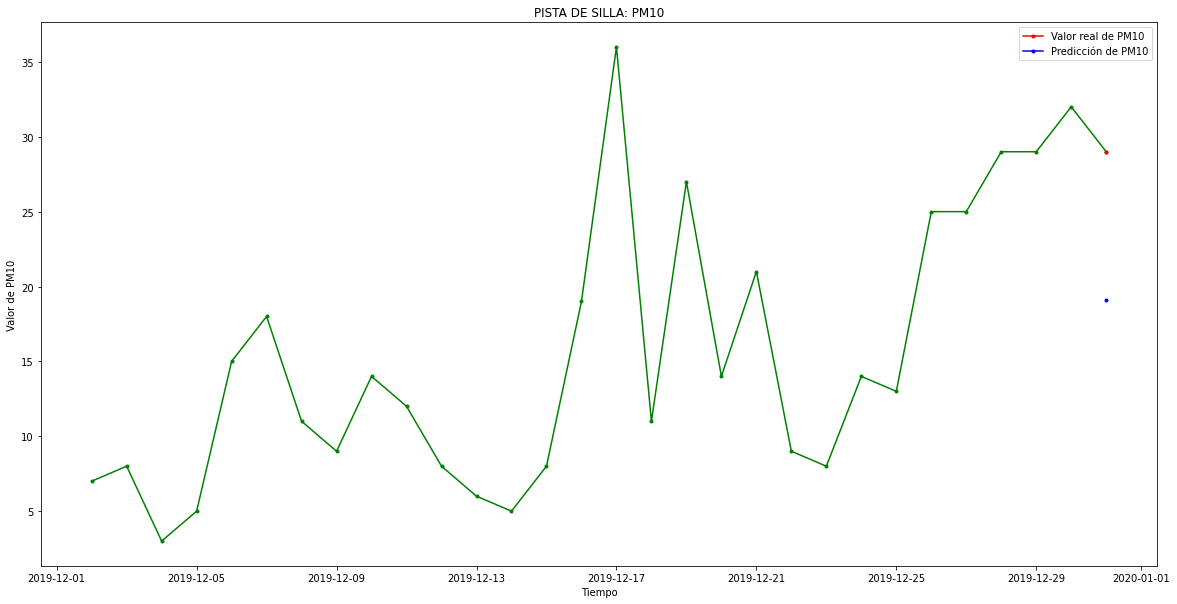

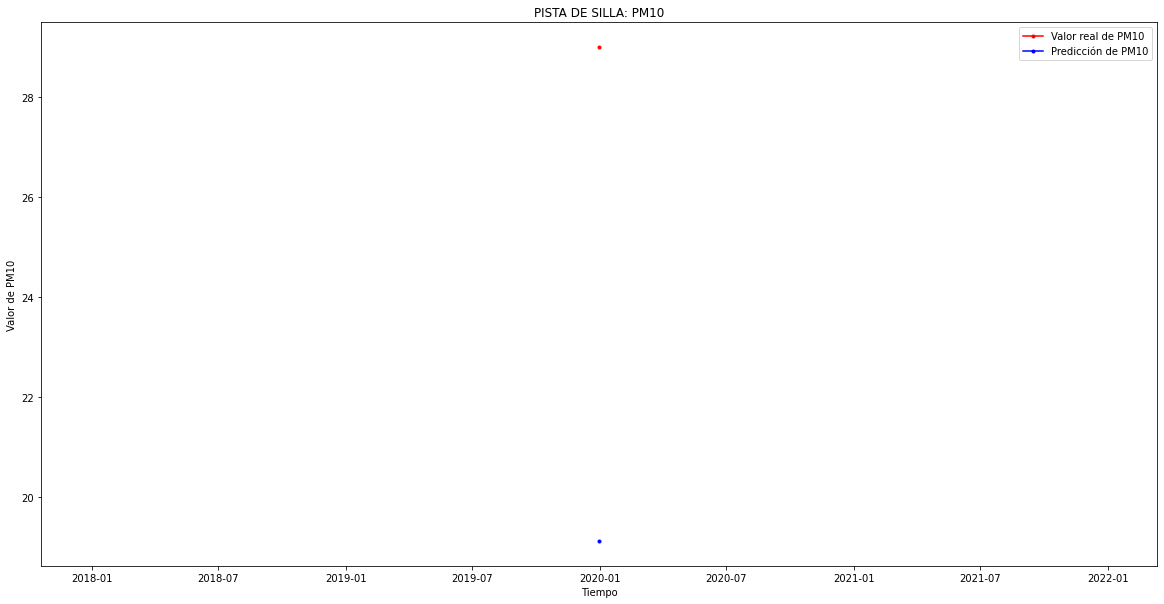

Modelo: 46250030 - PM10 / Error cuadrático medio:  9.885 / Error absoluto medio:  9.885

            PM10       FECHA  Prediccion
fecha                                   
2019-12-31  29.0  2020-01-01   19.115124
Procesando estacion: 46250046 - POLITÈCNIC

Procesando atributo: PM10

resultados:
                 FECHA  PM10
fecha                       
2019-12-31  2019-12-31  38.0
fechaPrediccion:  2020-01-01 00:00:00


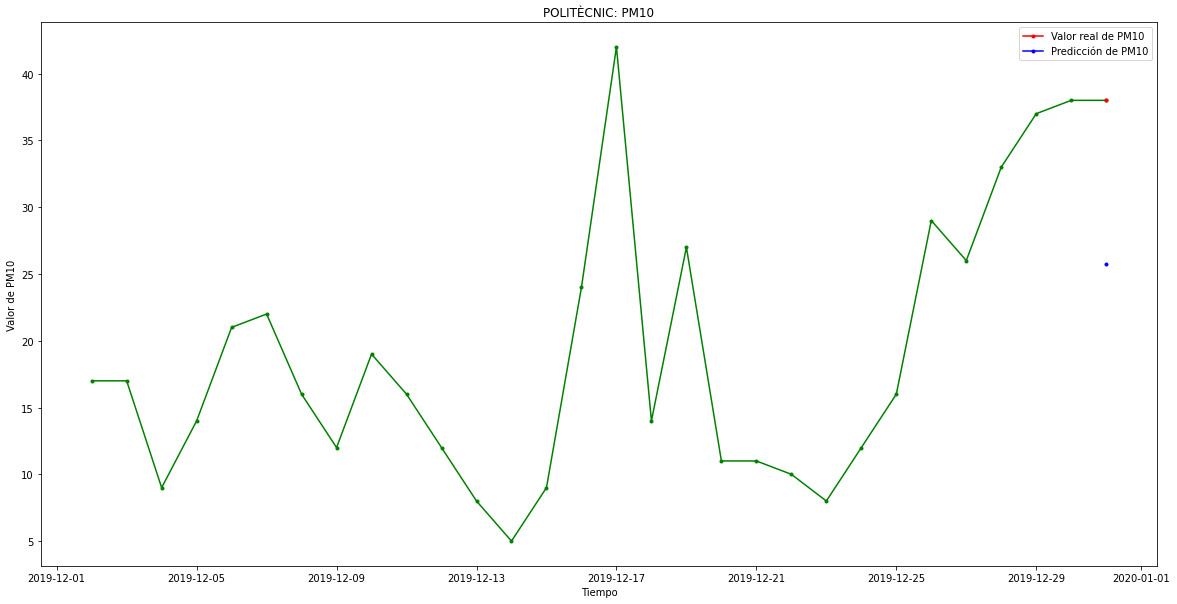

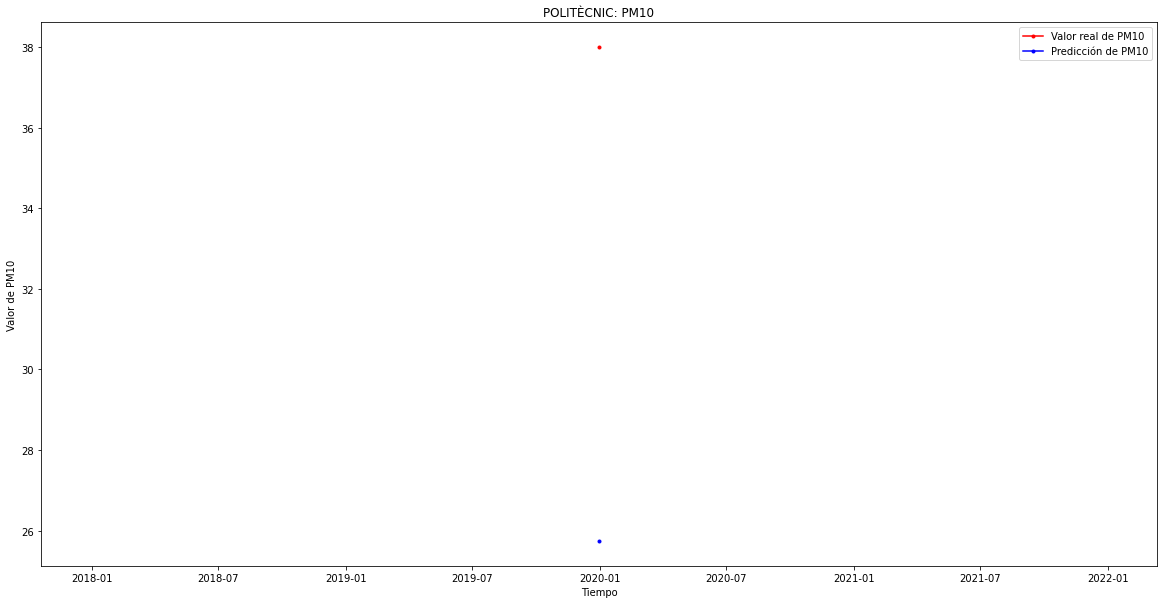

Modelo: 46250046 - PM10 / Error cuadrático medio: 12.262 / Error absoluto medio: 12.262

            PM10       FECHA  Prediccion
fecha                                   
2019-12-31  38.0  2020-01-01    25.73805
Procesando estacion: 46250047 - AVD. FRANCIA

Procesando atributo: PM10

resultados:
                 FECHA  PM10
fecha                       
2019-12-31  2019-12-31  34.0
fechaPrediccion:  2020-01-01 00:00:00


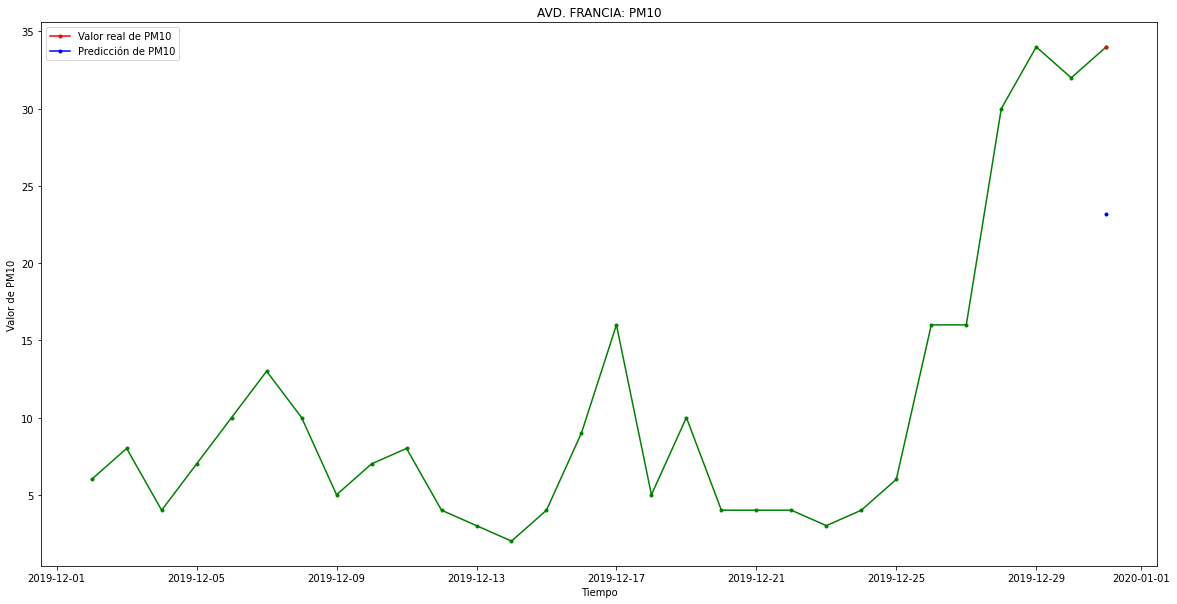

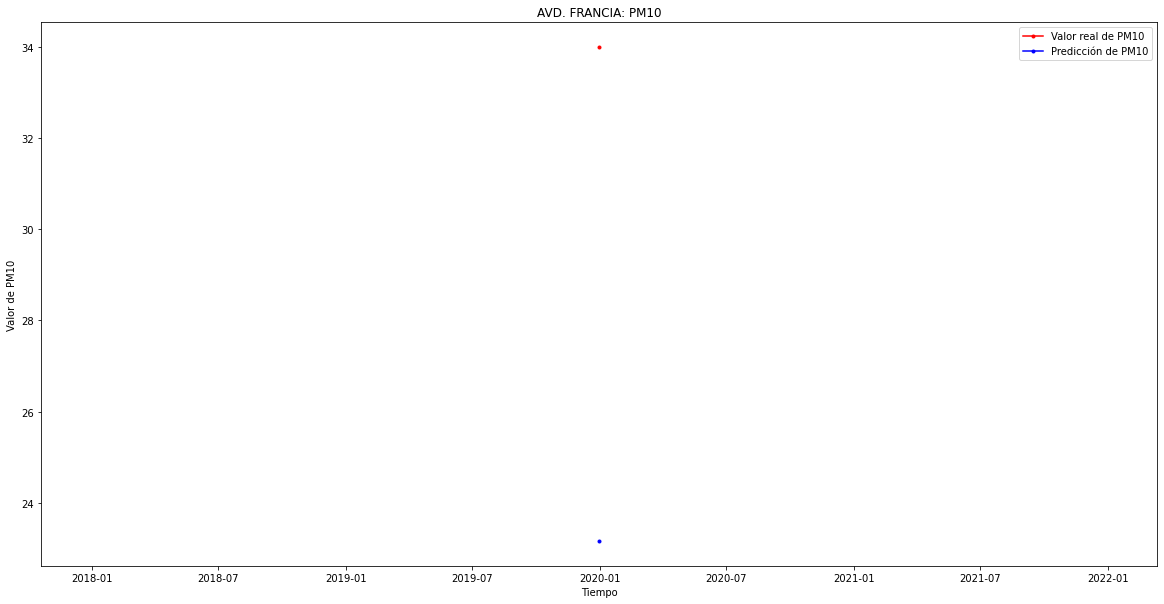

Modelo: 46250047 - PM10 / Error cuadrático medio: 10.843 / Error absoluto medio: 10.843

            PM10       FECHA  Prediccion
fecha                                   
2019-12-31  34.0  2020-01-01   23.157059
Procesando estacion: 46250048 - MOLÍ DEL SOL

Procesando atributo: PM10

resultados:
                 FECHA  PM10
fecha                       
2019-12-31  2019-12-31  39.0
fechaPrediccion:  2020-01-01 00:00:00


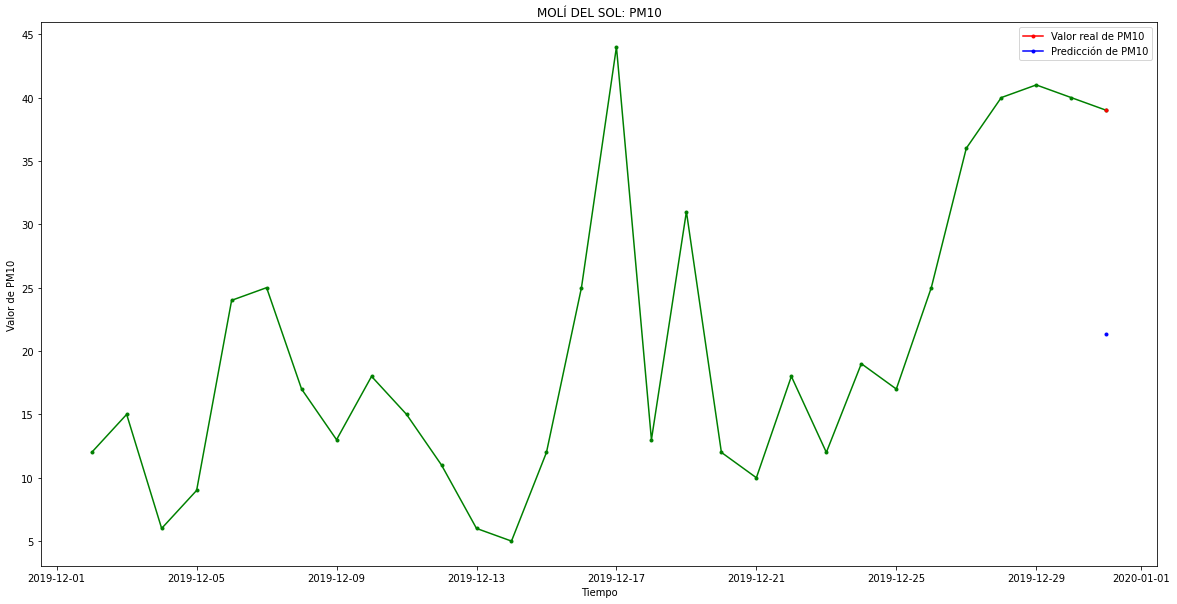

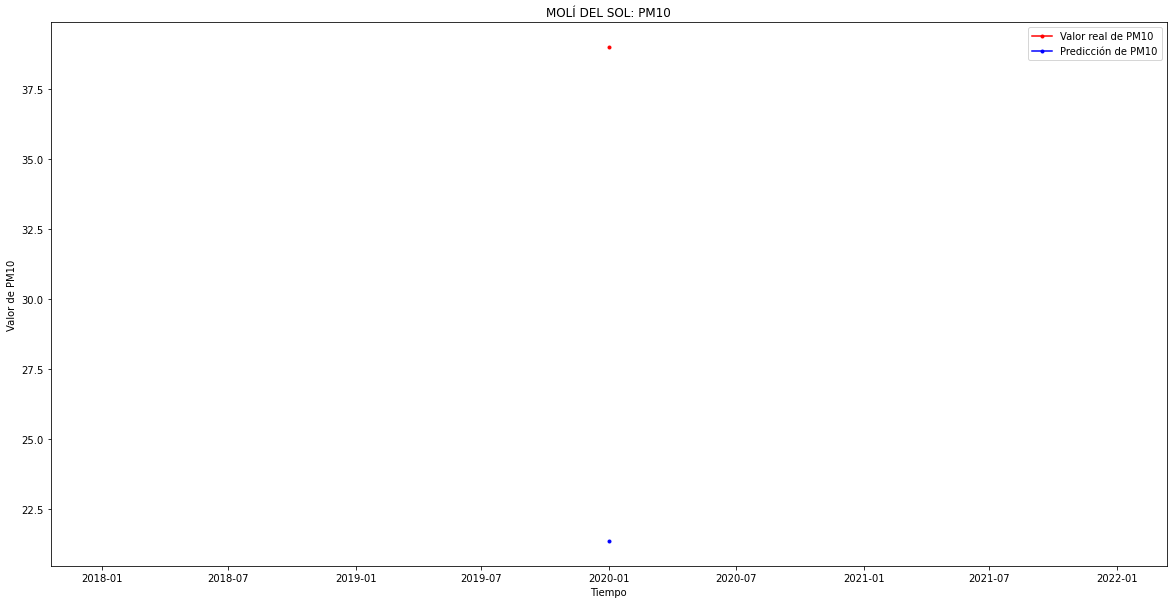

Modelo: 46250048 - PM10 / Error cuadrático medio: 17.663 / Error absoluto medio: 17.663

            PM10       FECHA  Prediccion
fecha                                   
2019-12-31  39.0  2020-01-01   21.337002


In [201]:
# Proceso principal

# print(dfCompleto['COD_ESTACION'].unique())
# print(dfCompleto['NOM_ESTACION'].unique())
cod_estaciones = dfCompleto['COD_ESTACION'].unique()
nom_estaciones = dfCompleto['NOM_ESTACION'].unique()
for cod_esta, nom_esta in zip(cod_estaciones, nom_estaciones):
  procesar_estacion(cod_esta, nom_esta, dfCompleto)